In [1]:
# -*- coding: utf-8 -*-
'''An implementation of sequence to sequence learning for performing addition
Input: "535+61"
Output: "596"
Padding is handled by using a repeated sentinel character (space)
Input may optionally be inverted, shown to increase performance in many tasks in:
"Learning to Execute"
http://arxiv.org/abs/1410.4615
and
"Sequence to Sequence Learning with Neural Networks"
http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf
Theoretically it introduces shorter term dependencies between source and target.
Two digits inverted:
+ One layer LSTM (128 HN), 5k training examples = 99% train/test accuracy in 55 epochs
Three digits inverted:
+ One layer LSTM (128 HN), 50k training examples = 99% train/test accuracy in 100 epochs
Four digits inverted:
+ One layer LSTM (128 HN), 400k training examples = 99% train/test accuracy in 20 epochs
Five digits inverted:
+ One layer LSTM (128 HN), 550k training examples = 99% train/test accuracy in 30 epochs
'''

'An implementation of sequence to sequence learning for performing addition\nInput: "535+61"\nOutput: "596"\nPadding is handled by using a repeated sentinel character (space)\nInput may optionally be inverted, shown to increase performance in many tasks in:\n"Learning to Execute"\nhttp://arxiv.org/abs/1410.4615\nand\n"Sequence to Sequence Learning with Neural Networks"\nhttp://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf\nTheoretically it introduces shorter term dependencies between source and target.\nTwo digits inverted:\n+ One layer LSTM (128 HN), 5k training examples = 99% train/test accuracy in 55 epochs\nThree digits inverted:\n+ One layer LSTM (128 HN), 50k training examples = 99% train/test accuracy in 100 epochs\nFour digits inverted:\n+ One layer LSTM (128 HN), 400k training examples = 99% train/test accuracy in 20 epochs\nFive digits inverted:\n+ One layer LSTM (128 HN), 550k training examples = 99% train/test accuracy in 30 epochs\n'

In [1]:
from __future__ import print_function
from keras.models import Sequential
from keras.engine.training import slice_X
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, recurrent
import numpy as np
from six.moves import range
from sklearn.metrics import accuracy_score

Using Theano backend.


In [2]:
class CharacterTable(object):
    '''
    Given a set of characters:
    + Encode them to a one hot integer representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    '''
    def __init__(self, chars, maxlen):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
        self.maxlen = maxlen

    def encode(self, C, maxlen=None):
        maxlen = maxlen if maxlen else self.maxlen
        X = np.zeros((maxlen, len(self.chars)))
        for i, c in enumerate(C):
            X[i, self.char_indices[c]] = 1
        return X

    def decode(self, X, calc_argmax=True):
        if calc_argmax:
            X = X.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in X)

In [3]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [7]:
# Parameters for the model and dataset
TRAINING_SIZE = 5000
DIGITS = 2
OPS = 2
INVERT = True
# Try replacing GRU, or SimpleRNN
RNN = recurrent.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1
MAXLEN = OPS * DIGITS + OPS - 1

In [8]:
chars = '0123456789+ '
ctable = CharacterTable(chars, MAXLEN)

In [9]:
def generate_data(training_size, num_digits, num_ops):
    MAXLEN = num_ops * num_digits + num_ops - 1
    questions = []
    expected = []
    seen = set()
    print('Generating data... ')
    while len(questions) < training_size:
        f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, num_digits + 1))))

        ops = []
        for i in range(num_ops):
            ops.append(f())
        # Skip any addition questions we've already seen
        # Also skip any such that X+Y == Y+X (hence the sorting)
        ops.sort()
        key = tuple(ops)
        if key in seen:
            continue
        seen.add(key)
        # Pad the data with spaces such that it is always MAXLEN
        q = '+'.join([str(op) for op in ops])
        query = q + ' ' * (MAXLEN - len(q))
        ans = str(sum(ops))
        # Answers can be of maximum size DIGITS + 1
        ans += ' ' * (num_digits + 1 - len(ans))
        if INVERT:
            query = query[::-1]
        questions.append(query)
        expected.append(ans)
    print('Total addition questions:', len(questions))
    
    return questions, expected

Generating data... 
Total addition questions: 5000


In [ ]:
questions, expected = generate_data(5000, 2, 2)

In [10]:
print('Vectorization...')
X = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    X[i] = ctable.encode(sentence, maxlen=MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, maxlen=DIGITS + 1)

# Shuffle (X, y) in unison as the later parts of X will almost all be larger digits
indices = np.arange(len(y))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over
split_at = len(X) - len(X) / 10
(X_train, X_val) = (slice_X(X, 0, split_at), slice_X(X, split_at))
(y_train, y_val) = (y[:split_at], y[split_at:])

print(X_train.shape)
print(y_train.shape)

Vectorization...
(4500, 5, 12)
(4500, 3, 12)


In [13]:
# Most simple seq2seq model using encoder-decoder framework
print('Build model...')
model = Sequential()
# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE
# note: in a situation where your input sequences have a variable length,
# use input_shape=(None, nb_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
# For the decoder's input, we repeat the encoded input for each time step
model.add(RepeatVector(DIGITS + 1))
# The decoder RNN could be multiple layers stacked or a single layer
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# For each of step of the output sequence, decide which character should be chosen
model.add(TimeDistributed(Dense(len(chars))))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Build model...


In [14]:
def learning(model, X_train, y_train, iterations, X_val, y_val):
    y_true = []
    for idx in range(y_val.shape[0]):
        y_true.append(ctable.decode(y_val[idx]))

    val_acc_array = []
    # Train the model each generation and show predictions against the validation dataset
    for iteration in range(1, 100):
        print()
        print('-' * 50)
        print('Iteration', iteration)
        model.fit(X_train, y_train, batch_size=BATCH_SIZE, nb_epoch=1,
                  validation_data=(X_val, y_val))
        ###
        # Select 10 samples from the validation set at random so we can visualize errors
    #     for i in range(10):
    #         ind = np.random.randint(0, len(X_val))
    #         rowX, rowy = X_val[np.array([ind])], y_val[np.array([ind])]
    #         preds = model.predict_classes(rowX, verbose=0)
    #         q = ctable.decode(rowX[0])
    #         correct = ctable.decode(rowy[0])
    #         guess = ctable.decode(preds[0], calc_argmax=False)
    #         print('Q', q[::-1] if INVERT else q)
    #         print('T', correct)
    #         print(colors.ok + '☑' + colors.close if correct == guess else colors.fail + '☒' + colors.close, guess)
    #         print('---')

        preds = model.predict_classes(X_val, verbose=0)
        y_preds = []
        for idx in range(preds.shape[0]):
            y_preds.append(ctable.decode(preds[idx], calc_argmax=False))

        acc = accuracy_score(y_true, y_preds)
        val_acc_array.append(acc)
        print('Current validation accuracy = ' + str(acc))
    
    return val_acc_array


--------------------------------------------------
Iteration 1
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 2s - loss: 2.2598 - acc: 0.2970 - val_loss: 2.0131 - val_acc: 0.3787
Current validation accuracy = 0.0

--------------------------------------------------
Iteration 2
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 2s - loss: 1.8395 - acc: 0.3888 - val_loss: 1.7574 - val_acc: 0.3993
Current validation accuracy = 0.004

--------------------------------------------------
Iteration 3
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 2s - loss: 1.7127 - acc: 0.4030 - val_loss: 1.6669 - val_acc: 0.3993
Current validation accuracy = 0.004

--------------------------------------------------
Iteration 4
Train on 4500 samples, validate on 500 samples
Epoch 1/1
4500/4500 [==============================] - 2s - loss: 1.6144 - acc

In [ ]:
val_acc_2_2 = learning(model, X_train, y_train, 100, X_val, y_val):

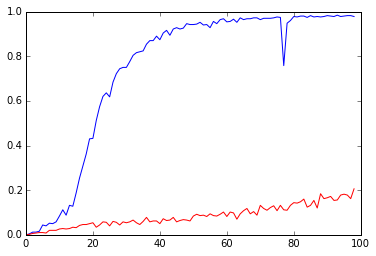

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.figure()
plt.plot(val_acc_array_2)
plt.plot(val_acc_array_3, 'r')

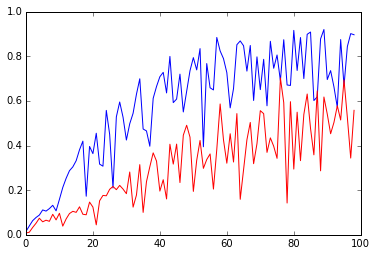

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.figure()
plt.plot(val_acc_array_2)
plt.plot(val_acc_array_3, 'r')

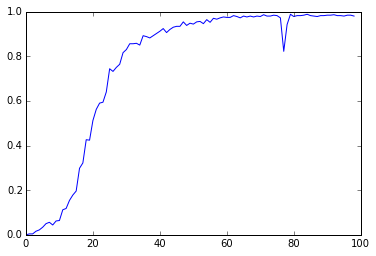

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.figure()
plt.plot(val_acc_array)